# **Transformer MM explainability- ViT (single modality)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

# !pip install -r requirements.txt
!pip install einops

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 362 (delta 104), reused 69 (delta 65), pack-reused 235
Receiving objects: 100% (362/362), 3.24 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (174/174), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
#@title WSSS4LUAD class indices to names
%%capture
CLS2IDX = {0: 'tumor',
           1: 'stroma',
           2: 'normal',}

# **ViT examples**

### ***Implementation of rules***

In [ ]:
# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input, register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for blk in model.blocks:
        grad = blk.attn.get_attn_gradients()
        cam = blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    return R[0, 1:]

In [ ]:
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit

In [ ]:
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize(resized),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy())

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = generate_relevance(model, original_image.unsqueeze(0).cuda(), index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print 3 predictions
    prob = torch.sigmoid(predictions)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [ ]:
test_image_path_1  = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training/436219-7159-48987-[1, 1, 0].png'
test_image_path_2  = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/cutmix_augmentation/0000-[0, 1, 1].png'
valid_image_path   = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_mask_path    = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
test_image_1 = cv2.imread(test_image_path_1)
test_image_1 = cv2.resize(test_image_1, (224, 224))

test_image_2 = cv2.imread(test_image_path_2)
test_image_2 = cv2.resize(test_image_2, (224, 224))

valid_image  = cv2.imread(valid_image_path)
valid_image  = cv2.resize(valid_image, (224, 224))

valid_mask   = cv2.imread(valid_mask_path)
valid_mask   = cv2.resize(valid_mask, (224, 224))

In [ ]:
test_image_1_tensor = preprocess_image(test_image_1).to(device)
test_image_2_tensor = preprocess_image(test_image_2).to(device)
valid_image_tensor  = preprocess_image(valid_image).to(device)

In [ ]:
# initialize ViT pretrained
# initialize ViT pretrained
model = vit(pretrained=False, num_classes = 3).cuda()

model.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_vit_base_patch16_224_01.pth',
                                                      map_location=torch.device(device)))
model.eval()

# Test image 1

In [ ]:
output = model(test_image_1_tensor.unsqueeze(0).cuda())
print_top_classes(output)

Top 5 classes:
	0 : tumor 		value = 15.872	 prob = 100.0%
	1 : stroma		value = 7.514	 prob = 99.9%
	2 : normal		value = -12.769	 prob = 0.0%


In [ ]:
# tumor - the predicted class
tumor = generate_visualization(test_image_1_tensor, class_index=0)

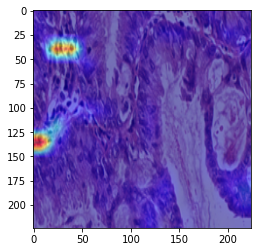

In [ ]:
plt.imshow(tumor)

In [ ]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(test_image_1_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(test_image_1_tensor, class_index=2)

(-0.5, 223.5, 223.5, -0.5)

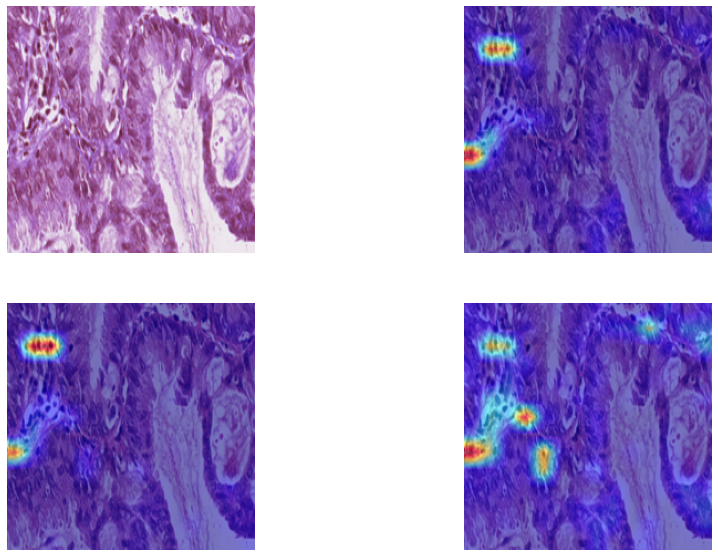

In [ ]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_1)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

## Test image 2

In [ ]:
output = model(test_image_2_tensor.unsqueeze(0).cuda())
print_top_classes(output)

Top 5 classes:
	2 : normal		value = 10.380	 prob = 100.0%
	1 : stroma		value = 4.526	 prob = 98.9%
	0 : tumor 		value = -7.184	 prob = 0.1%


In [ ]:
# tumor - the predicted class
tumor = generate_visualization(test_image_2_tensor, class_index=0)

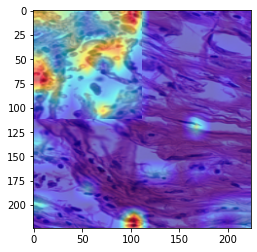

In [ ]:
plt.imshow(tumor)

In [ ]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(test_image_2_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(test_image_2_tensor, class_index=2)

(-0.5, 223.5, 223.5, -0.5)

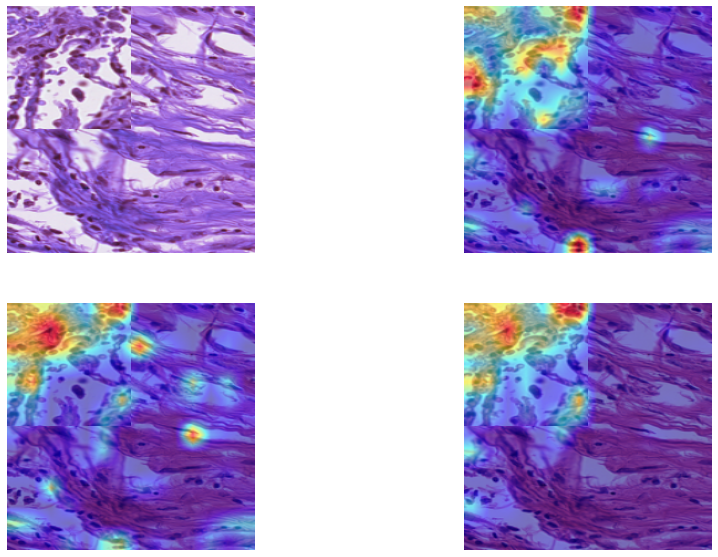

In [ ]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_2)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')

## Valid Image

In [ ]:
output = model(valid_image_tensor.unsqueeze(0).cuda())
print_top_classes(output)

Top 5 classes:
	0 : tumor 		value = 17.968	 prob = 100.0%
	1 : stroma		value = 11.708	 prob = 100.0%
	2 : normal		value = -14.349	 prob = 0.0%


In [ ]:
# tumor - the predicted class
tumor = generate_visualization(valid_image_tensor, class_index=0)

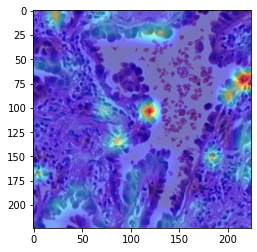

In [ ]:
plt.imshow(tumor)

In [ ]:
# stroma 
# generate visualization for class 1: 'stroma'
stroma = generate_visualization(valid_image_tensor, class_index=1)

# stroma 
# generate visualization for class 2: 'normal'
normal = generate_visualization(valid_image_tensor, class_index=2)

(-0.5, 223.5, 223.5, -0.5)

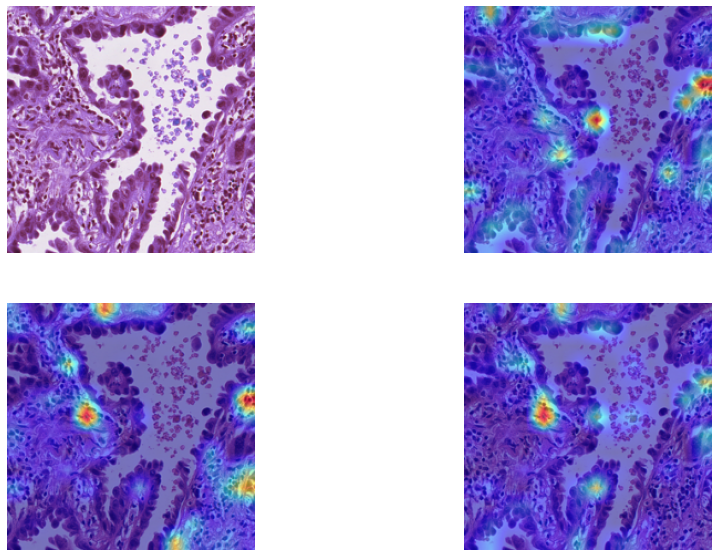

In [ ]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(valid_image)
ax.axis('off')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(tumor)
ax.axis('off')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(stroma)
ax.axis('off')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(normal)
ax.axis('off')